#DATA 410 Lecture 16 - Spring 2022

<font face="Chalkboard" color="darkgreen" size=10>Real and Synthetic Data Applications with Variable Selection Algorithms</font>

## Data Simulations for Linear Regression & Variable Selection/Regularization

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [2]:
# This is important: update the statsmodels package
#! pip install --upgrade Cython
#! pip install --upgrade git+https://github.com/statsmodels/statsmodels
import statsmodels.api as sm

In [3]:
# general imports
import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_spd_matrix
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import toeplitz
from matplotlib import pyplot

## For simulating multiple correlations we use a Toeplitz matrix

In [4]:
toeplitz([1,2,3,4,5])

array([[1, 2, 3, 4, 5],
       [2, 1, 2, 3, 4],
       [3, 2, 1, 2, 3],
       [4, 3, 2, 1, 2],
       [5, 4, 3, 2, 1]])

In [6]:
toeplitz([1,0.9,0.85**2,0.89**3])

array([[1.      , 0.9     , 0.7225  , 0.704969],
       [0.9     , 1.      , 0.9     , 0.7225  ],
       [0.7225  , 0.9     , 1.      , 0.9     ],
       [0.704969, 0.7225  , 0.9     , 1.      ]])

## What is the connection between correlation and covariance?

$$corr(X,Y) = \frac{{Cov(X,Y)}}{\sigma_X\cdot\sigma_Y}$$

In [59]:
# this is a simpler example for creating synthetic data with a given (prescribed) covariance matrix and 4 input features
num_samples =200
sigma = 5

# The desired mean values of the sample.
mu = np.array([0.0, 0.0, 0.0, 0.0])

rho = 0.9
# The desired covariance matrix.
r = toeplitz([1,rho,rho**2,rho**3])
print(r)

# Generate the random samples.
X = np.random.multivariate_normal(mu, r, size=num_samples) #make some fake data
beta = np.array([2,0,-3, 0]).reshape(-1,1) #The beta that are the actual weights; in the real world only God konws this, we try to model them
y = np.matmul(X,beta) + sigma*np.random.normal(0,1,[num_samples,1]) #actual target plus std times a random.normal noise

[[1.    0.9   0.81  0.729]
 [0.9   1.    0.9   0.81 ]
 [0.81  0.9   1.    0.9  ]
 [0.729 0.81  0.9   1.   ]]


In [60]:
#rho =0.8
#p = 20
#vcor = []
#for i in range(p):
#  vcor.append(rho**i)
#print(vcor)

In [61]:
#np.repeat(0,20)

In [62]:
# we want to define a function for generating X with a prescribed number of obsvervations, features and Toeplitz correlation structure.
def make_correlated_features(num_samples,p,rho):
  vcor = [] 
  for i in range(p):
    vcor.append(rho**i)
  r = toeplitz(vcor)
  mu = np.repeat(0,p)
  X = np.random.multivariate_normal(mu, r, size=num_samples)
  return X

In [63]:
#X = make_correlated_features(200,20,0.75)

## Simulate some ground truth:

In [64]:
#beta =np.array([-1,2,3,0,0,0,0,2,-1,4])

In [65]:
#beta = beta.reshape(-1,1)
#p = 20
#betas = np.concatenate([beta,np.repeat(0,p-len(beta)).reshape(-1,1)],axis=0)
# this is our simulated ground truth
#betas

In [66]:
#n =200
#sigma = 2
#y = X.dot(betas) + sigma*np.random.normal(0,1,n).reshape(-1,1)

In [67]:
#y.shape

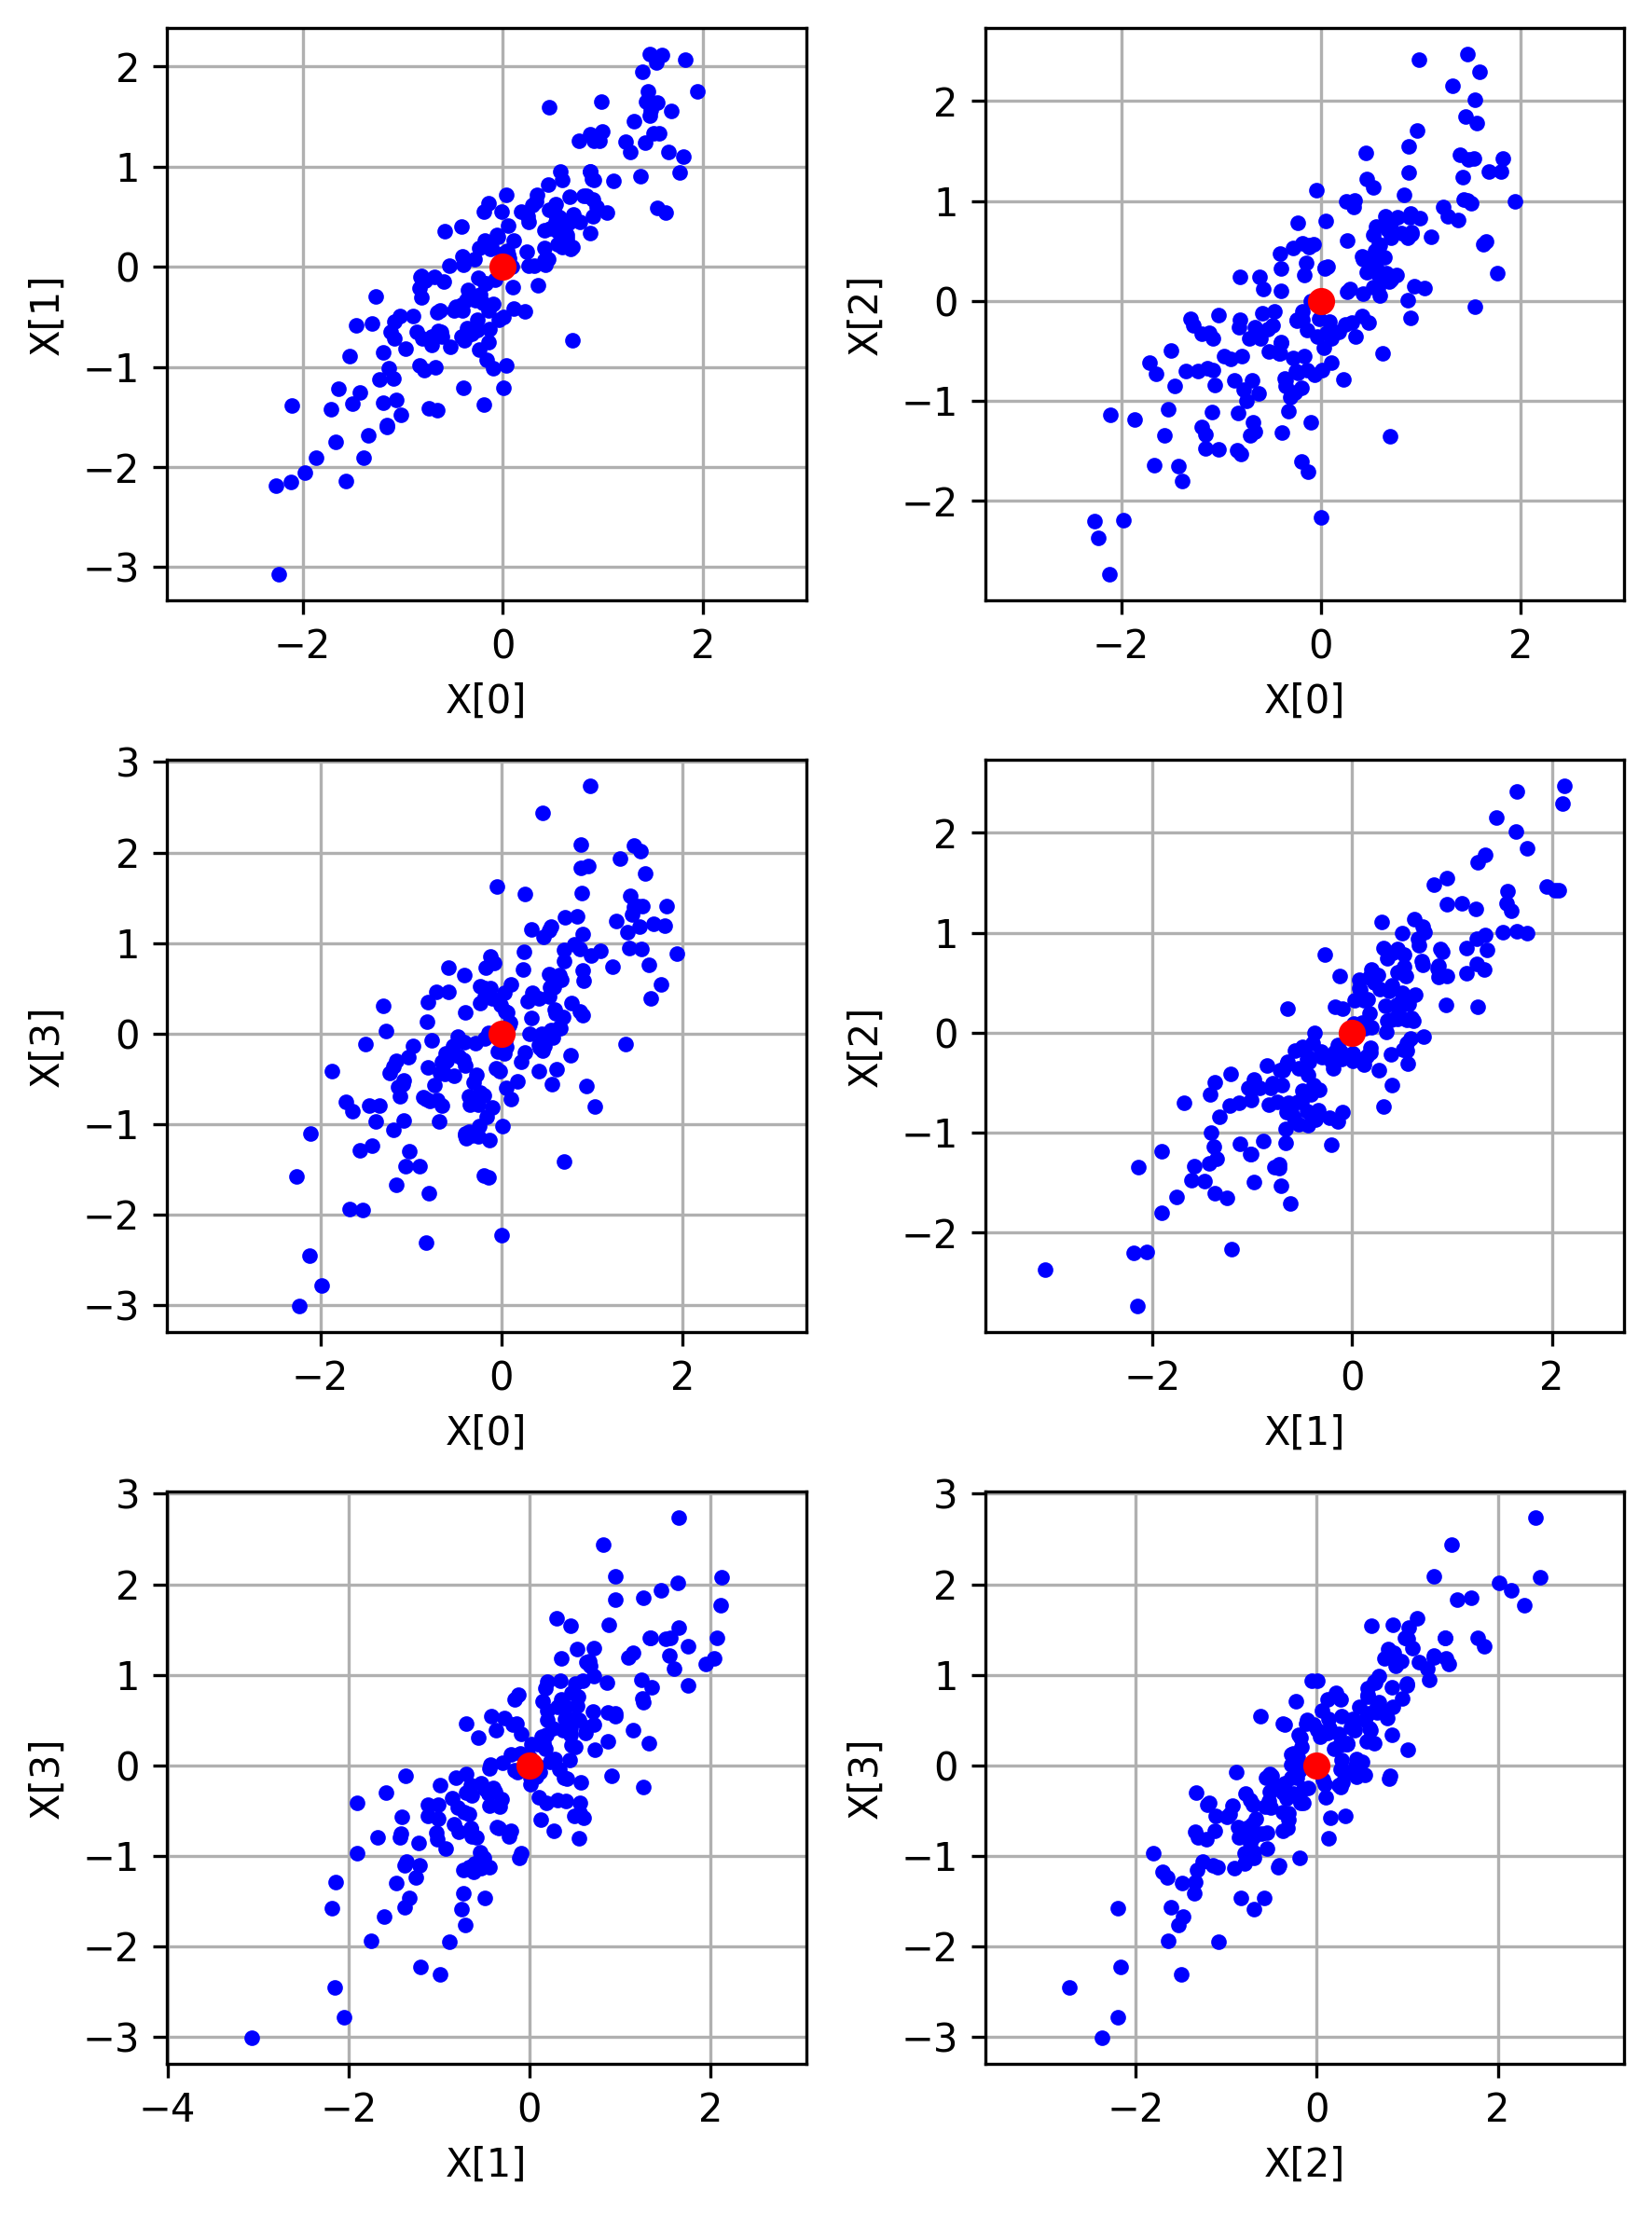

In [68]:
# Plot various projections of the samples.

fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(6,8))

plt.subplot(3,2,1)
plt.plot(X[:,0], X[:,1], 'b.')
plt.plot(mu[0], mu[1], 'ro')
plt.xlabel('X[0]')
plt.ylabel('X[1]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,2)
plt.plot(X[:,0], X[:,2], 'b.')
plt.plot(mu[0], mu[2], 'ro')
plt.xlabel('X[0]')
plt.ylabel('X[2]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,3)
plt.plot(X[:,0], X[:,3], 'b.')
plt.plot(mu[0], mu[3], 'ro')
plt.xlabel('X[0]')
plt.ylabel('X[3]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,4)
plt.plot(X[:,1], X[:,2], 'b.')
plt.plot(mu[1], mu[2], 'ro')
plt.xlabel('X[1]')
plt.ylabel('X[2]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,5)
plt.plot(X[:,1], X[:,3], 'b.')
plt.plot(mu[1], mu[3], 'ro')
plt.xlabel('X[1]')
plt.ylabel('X[3]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,6)
plt.plot(X[:,2], X[:,3], 'b.')
plt.plot(mu[2], mu[3
                   ], 'ro')
plt.xlabel('X[2]')
plt.ylabel('X[3]')
plt.axis('equal')
plt.grid(True)
fig.tight_layout()
plt.show()

### Now apply the different models

In [69]:
model  = LinearRegression(fit_intercept=False)
model.fit(X,y)
model.coef_

array([[ 1.60723961,  1.03004766, -3.32237962, -0.09746442]])

In [80]:
model = Lasso(alpha=0.2, fit_intercept=False)
model.fit(X,y)
model.coef_

array([ 1.07838354,  0.        , -1.86847199, -0.        ])

In [89]:
model = Ridge(alpha=0.2, fit_intercept=False)
model.fit(X,y)
model.coef_

array([[ 1.60459402,  1.01244771, -3.2875745 , -0.11172176]])

In [85]:
model = ElasticNet(alpha=0.2,l1_ratio=0.75, fit_intercept=False)
model.fit(X,y)
model.coef_

array([ 1.02338974,  0.        , -1.55646174, -0.25486137])

In [90]:
#SCAD?

## Square Root Lasso

https://arxiv.org/abs/1009.5689

*Square Root Lasso* is also based on minimizing an objective function plus a $L_1$ constraint (penalty).

For example, *Square Root Lasso* is represented by the following optimization problem:

$$
\displaystyle\text{minimize} \sqrt{\frac{1}{n}\sum\limits_{i=1}^{n}(y_i-\hat{y}_i)^2} +\alpha\sum\limits_{i=1}^{p}|\beta_i|
$$

In [97]:
model = sm.OLS(y,X)
result = model.fit_regularized(method='sqrt_lasso', alpha=5)
result.params

array([ 1.48610439e+00,  1.69366931e-06, -2.26411145e+00, -5.06058471e-05])

## Higher dimensional synthetic data

In [98]:
num_samples =300

# The desired mean values of the sample.
mu = np.array([1, 2, 3, 0, 0, 0, 0, 4, 5,0])

# The desired covariance matrix.
r = make_spd_matrix(10,random_state=2021)

# Generate the random samples.
X = np.random.multivariate_normal(mu, r, size=num_samples)
beta = np.array([2,-3,-3,0, 0, 0, 0,-1,10,0]).reshape(-1,1)
y = np.matmul(X,beta) + 1.5*np.random.normal(0,1,[num_samples,1])

In [99]:
X.dot(beta).shape

(300, 1)

## SCAD

For next project, apply a gradient descent for obtaining the results from SCAD and optimize the learning rate with Borwein's formula.

Excersize: Make our own gradient descent method

To vectorize these scad functions, can use numba and @jit (just in time) compilation

""" from numba import jit ""

In [100]:
@jit
def scad_penalty(beta_hat, lambda_val, a_val):
    is_linear = (np.abs(beta_hat) <= lambda_val)
    is_quadratic = np.logical_and(lambda_val < np.abs(beta_hat), np.abs(beta_hat) <= a_val * lambda_val)
    is_constant = (a_val * lambda_val) < np.abs(beta_hat)
    
    linear_part = lambda_val * np.abs(beta_hat) * is_linear
    quadratic_part = (2 * a_val * lambda_val * np.abs(beta_hat) - beta_hat**2 - lambda_val**2) / (2 * (a_val - 1)) * is_quadratic
    constant_part = (lambda_val**2 * (a_val + 1)) / 2 * is_constant
    return linear_part + quadratic_part + constant_part
    
def scad_derivative(beta_hat, lambda_val, a_val):
    return lambda_val * ((beta_hat <= lambda_val) + (a_val * lambda_val - beta_hat)*((a_val * lambda_val - beta_hat) > 0) / ((a_val - 1) * lambda_val) * (beta_hat > lambda_val))

In [101]:
def scad(beta):
  beta = beta.flatten()
  beta = beta.reshape(-1,1)
  n = len(y)
  return 1/n*np.sum((y-X.dot(beta))**2) + np.sum(scad_penalty(beta,lam,a))
  
def dscad(beta):
  beta = beta.flatten()
  beta = beta.reshape(-1,1)
  n = len(y)
  return np.array(-2/n*np.transpose(X).dot(y-X.dot(beta))+scad_derivative(beta,lam,a)).flatten()

In [102]:
p = X.shape[1]
b0 = np.random.normal(1,1,p)

In [103]:
b0

array([ 1.26454226, -0.61872492,  1.04404078,  1.67456014, -0.46227272,
       -0.28765486,  0.602594  ,  0.87970509,  1.01247898,  1.0458113 ])

In [104]:
lam = 1
a = 2
output = minimize(scad, b0, method='L-BFGS-B', jac=dscad,options={'gtol': 1e-8, 'maxiter': 50000,'maxls': 25,'disp': True})

In [105]:
output.x

array([ 3.21371825, -3.12298167, -2.52131506, -0.84949187, -1.24098904,
       -1.95180409, -1.18013483, -1.29149175,  9.80464708, -1.77089657])

In [106]:
lam = 2
a = 1.01

In [107]:
dscad(b0)

array([ -55.06940394,  -55.3876782 ,  -87.98154326,    1.23791738,
         35.12308866,   14.61099394,    1.81210024, -127.71794755,
       -233.64153855,  -31.73966463])

In [108]:
beta = np.arange(-10,10,.01)
y = scad_penalty(beta,lam,a)

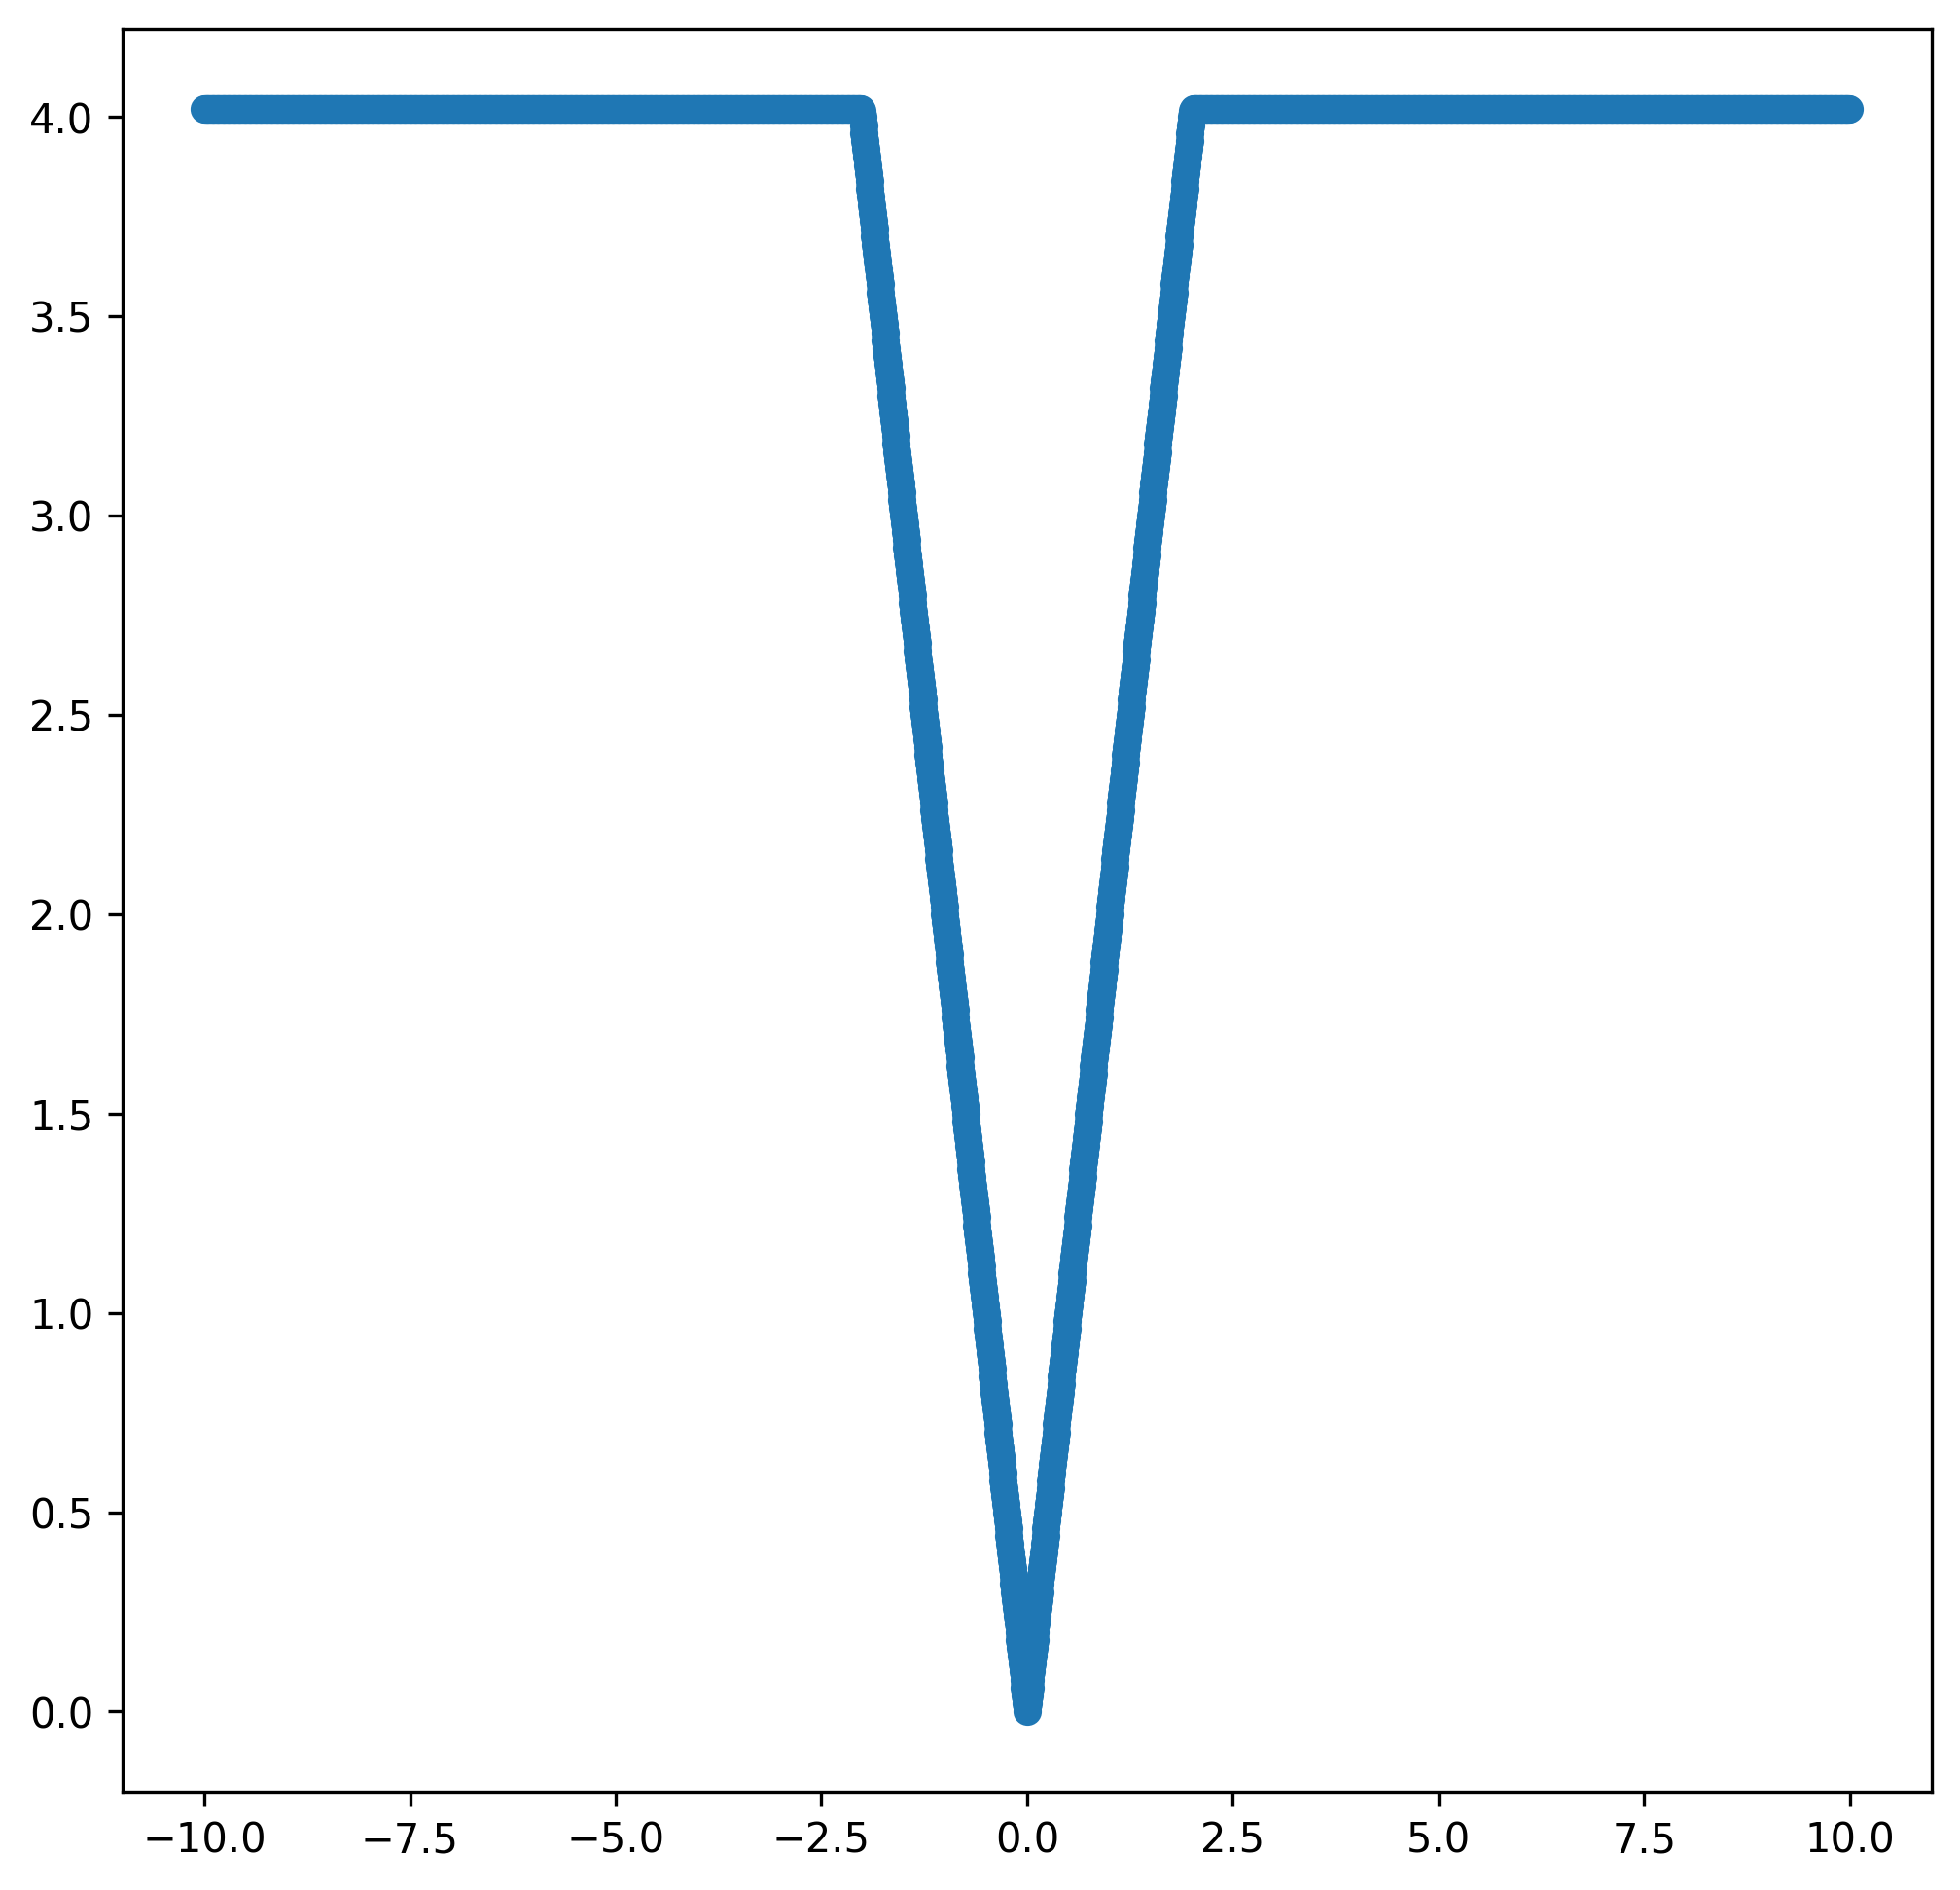

In [109]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(beta,y)

## Grid Search application for choosing the optimal hyperparameters.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
%%time
model = ElasticNet()
params = [{'alpha':np.linspace(0.001,1,num=50),'l1_ratio':np.linspace(0,1,num=50)}]
gs = GridSearchCV(estimator=model,cv=10,scoring='neg_mean_squared_error',param_grid=params)
gs_results = gs.fit(X,y)
print(gs_results.best_params_)
print('The mean square error is: ', np.abs(gs_results.best_score_))

## Example of Stepwise Regression

In [ ]:
# Implementation of stepwise regression
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details """
    
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

## Ranking Variables (this is relative to the context/model)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=310, max_depth=10,n_estimators=100)
df=pd.get_dummies(df)
model.fit(df,y)

In [ ]:
features = df.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()